# Reinforcement Learning Metrics – Exploratory Data Analysis

Dieses Notebook lädt TensorBoard‑Event‑Dateien eines RL‑Trainingslaufs, inspiziert die verfügbaren Metriken und erzeugt zusätzliche Visualisierungen (u. a. Boxplots), um die Ergebnisse aussagekräftiger darzustellen.



In [1]:
import os
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
logdir = "runs\ALE\SpaceInvaders-v5__ppo_clean_rl__1__20250612_134838"
print(f"Verwende logdir: {logdir}")

Verwende logdir: runs\ALE\SpaceInvaders-v5__ppo_clean_rl__1__20250612_134838


In [3]:
def load_scalars(log_dir):
    ea = event_accumulator.EventAccumulator(
        log_dir,
        size_guidance={event_accumulator.SCALARS: 0}
    )
    ea.Reload()
    scalars = ea.Tags().get('scalars', [])
    all_items = []
    for tag in scalars:
        for ev in ea.Scalars(tag):
            all_items.append({'step': ev.step,
                              'wall_time': ev.wall_time,
                              'tag': tag,
                              'value': ev.value})
    df = pd.DataFrame(all_items)
    return df

df = load_scalars(logdir)
print(f"Gelesene Werte: {len(df):,}")

Gelesene Werte: 2,958


In [4]:
print("Verfügbare Scalar‑Tags:")
for t in sorted(df['tag'].unique()):
    print("  •", t)

Verfügbare Scalar‑Tags:
  • charts/StepPerSecond
  • charts/learning_rate
  • eval/episodic_length
  • eval/episodic_return
  • eval/episodic_time
  • losses/approx_kl
  • losses/clipfrac
  • losses/entropy
  • losses/explained_variance
  • losses/old_approx_kl
  • losses/policy_loss
  • losses/value_loss
  • train/episodic_length
  • train/episodic_return
  • train/episodic_time


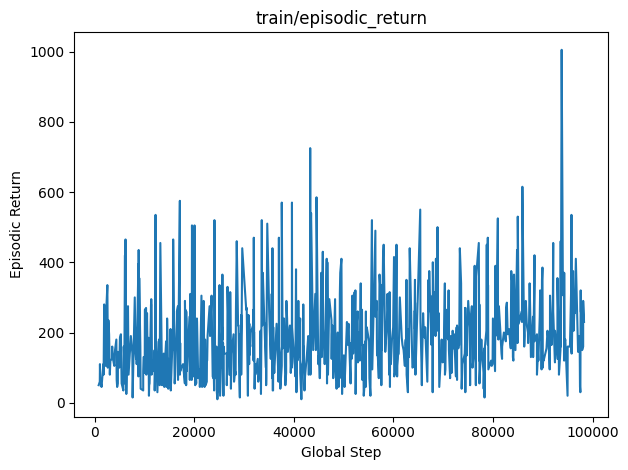

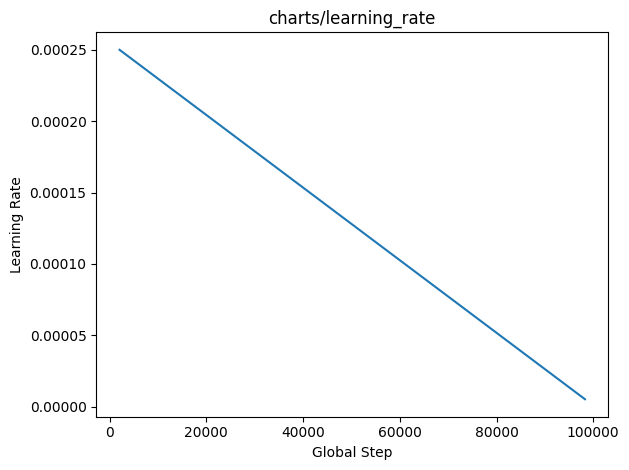

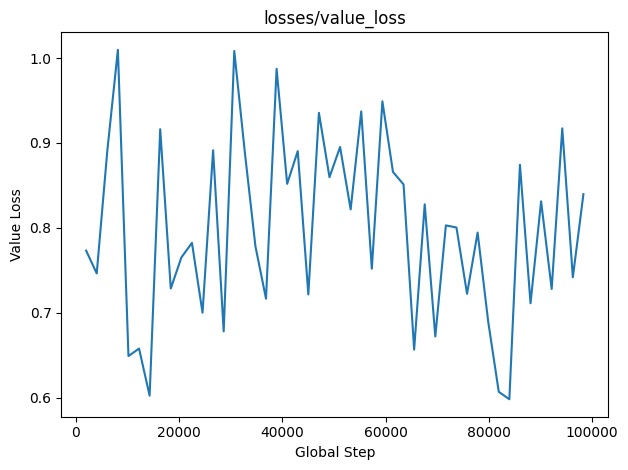

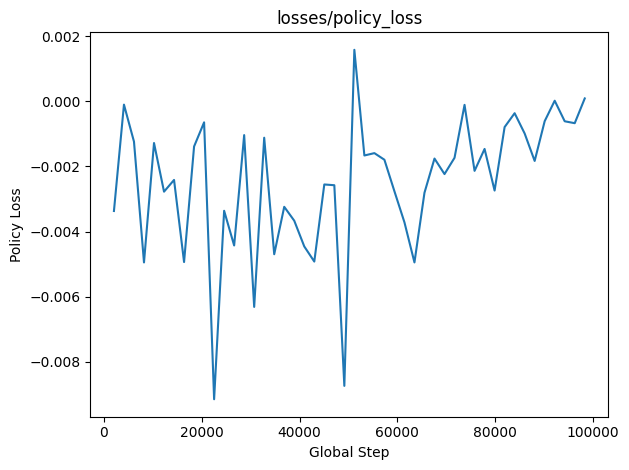

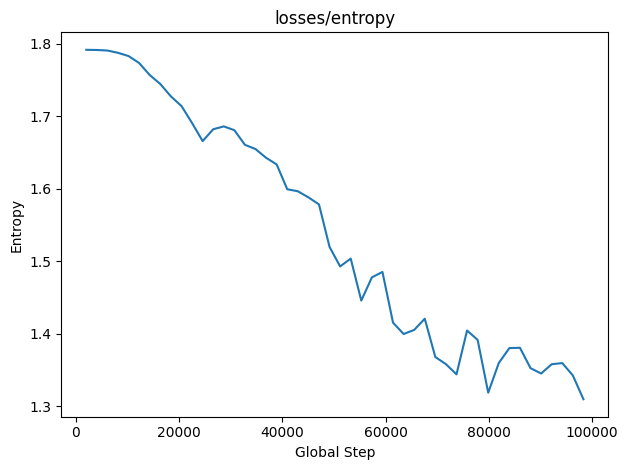

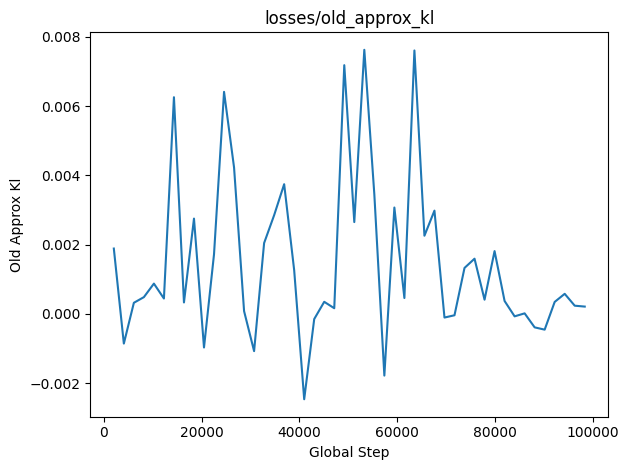

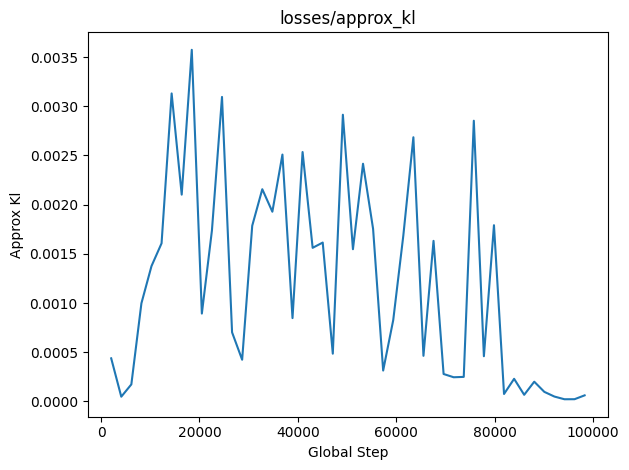

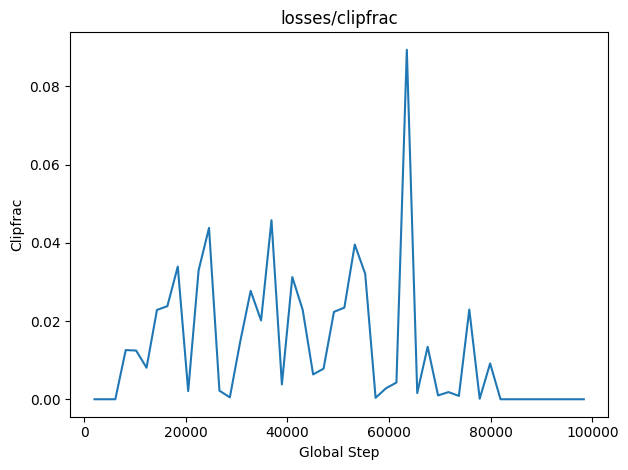

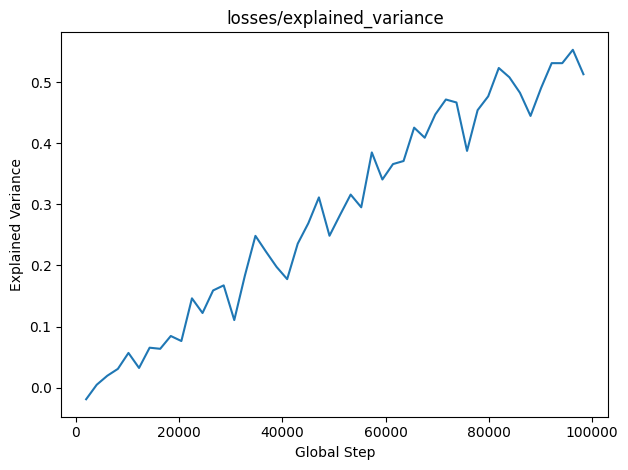

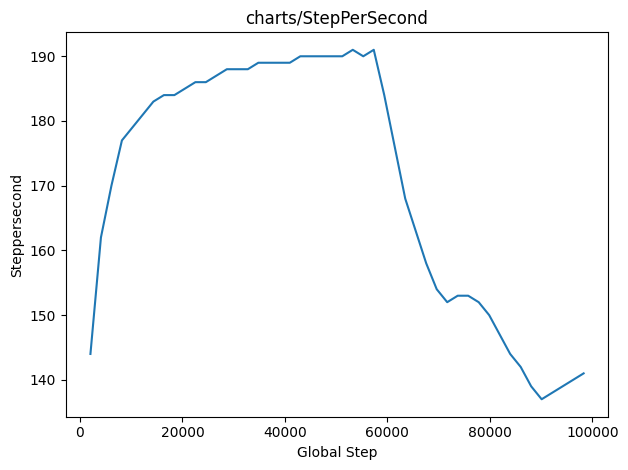

In [5]:
train_tags = [
    'train/episodic_return', 'charts/learning_rate', 'losses/value_loss',
    'losses/policy_loss', 'losses/entropy', 'losses/old_approx_kl',
    'losses/approx_kl', 'losses/clipfrac', 'losses/explained_variance',
    'charts/StepPerSecond'
]

for tag in train_tags:
    if tag in df['tag'].values:
        subset = df[df['tag'] == tag].sort_values('step')
        plt.figure()
        plt.plot(subset['step'], subset['value'])
        plt.title(tag)
        plt.xlabel('Global Step')
        plt.ylabel(tag.split('/')[-1].replace('_', ' ').title())
        plt.tight_layout()
        plt.show()

,episode,value
count,100.000000,100.000000
mean,50.500000,212.200000
std,29.011492,125.493611
min,1.000000,25.000000
25%,25.750000,120.000000
50%,50.500000,190.000000
75%,75.250000,280.000000
max,100.000000,695.000000


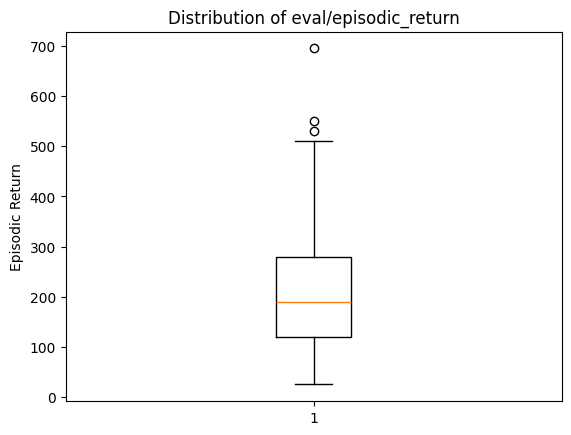

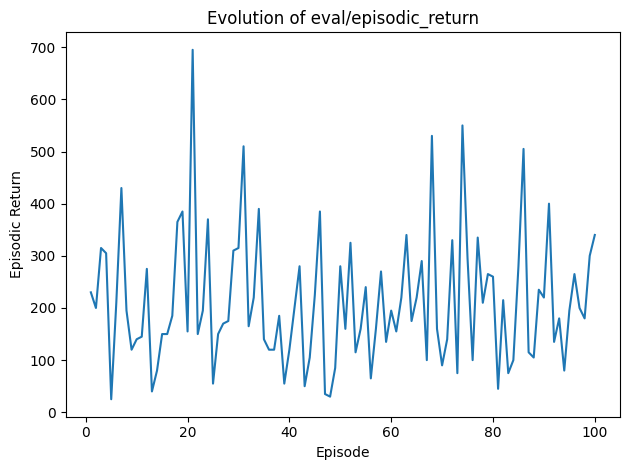

,episode,value
count,100.000000,100.000000
mean,50.500000,577.510000
std,29.011492,202.547139
min,1.000000,248.000000
25%,25.750000,449.500000
50%,50.500000,530.000000
75%,75.250000,717.750000
max,100.000000,1385.000000


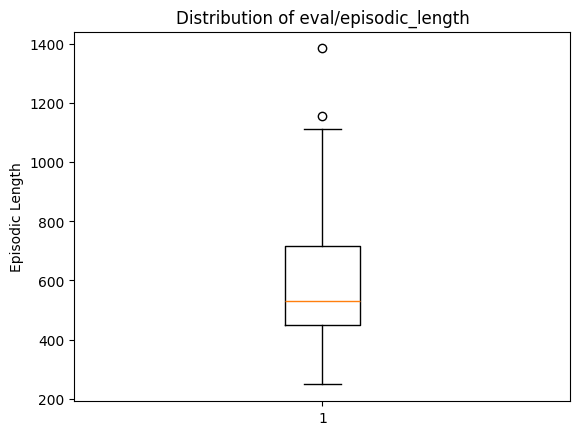

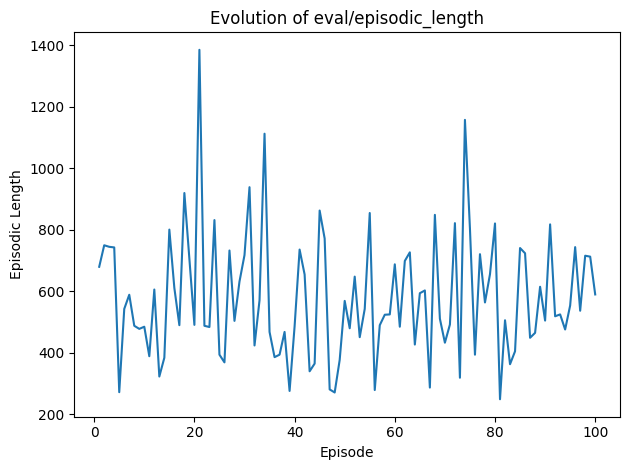

,episode,value
count,100.000000,100.000000
mean,50.500000,2.041434
std,29.011492,1.107595
min,1.000000,0.579548
25%,25.750000,1.247468
50%,50.500000,1.761011
75%,75.250000,2.404095
max,100.000000,6.426688


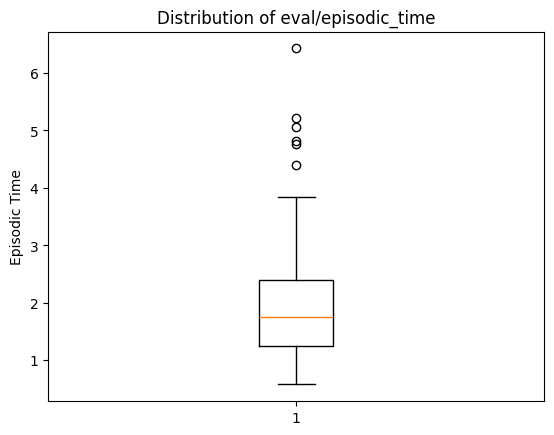

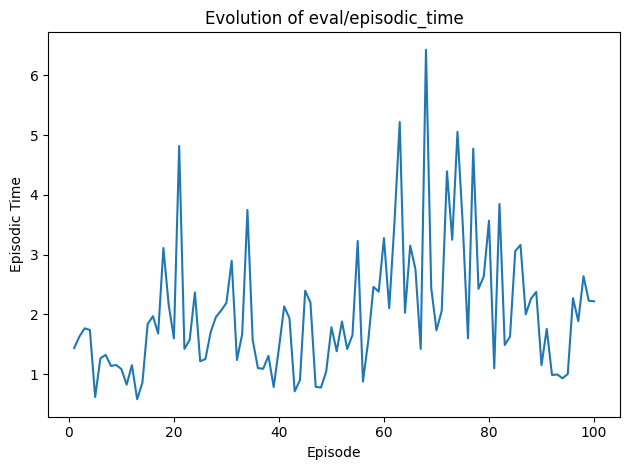

In [6]:
eval_tags = ['eval/episodic_return', 'eval/episodic_length', 'eval/episodic_time']

for tag in eval_tags:
    if tag in df['tag'].values:
        subset = df[df['tag'] == tag].copy()
        subset['episode'] = range(1, len(subset) + 1)
        display(subset[['episode', 'value']].describe())

        # Boxplot
        plt.figure()
        plt.boxplot(subset['value'])
        plt.title(f'Distribution of {tag}')
        plt.ylabel(tag.split('/')[-1].replace('_', ' ').title())
        plt.show()

        # Verlauf als Linienplot
        plt.figure()
        plt.plot(subset['episode'], subset['value'])
        plt.title(f'Evolution of {tag}')
        plt.xlabel('Episode')
        plt.ylabel(tag.split('/')[-1].replace('_', ' ').title())
        plt.tight_layout()
        plt.show()

<Figure size 1000x400 with 0 Axes>

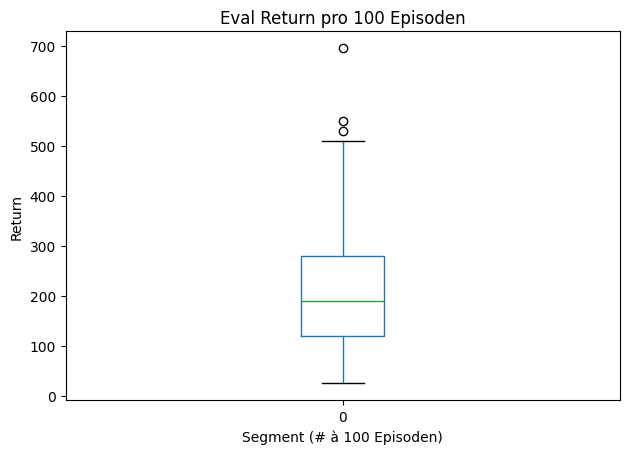

In [7]:
# Beispiel: Returns pro 100 Episoden gruppieren
import numpy as np
tag = 'eval/episodic_return'
if tag in df['tag'].values:
    subset = df[df['tag'] == tag].copy().reset_index(drop=True)
    subset['segment'] = np.floor_divide(subset.index, 100)
    plt.figure(figsize=(10, 4))
    subset.boxplot(column='value', by='segment', grid=False)
    plt.suptitle('')
    plt.title('Eval Return pro 100 Episoden')
    plt.xlabel('Segment (# à 100 Episoden)')
    plt.ylabel('Return')
    plt.tight_layout()
    plt.show()